In [1]:
import os, time, pickle, psutil, torch
import gymnasium as gym
import highway_env                   # enregistre les env Highway
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
import matplotlib.pyplot as plt
os.environ['TF_ENABLE_ONEDNN_OPTS']="0"
### ↓↓↓ OPTIMISATIONS CPU ↓↓↓
os.environ["OMP_NUM_THREADS"]  = "1"   # pour éviter l’over-threading
torch.set_num_threads(1)

LOG_DIR   = "../logs/racetrack_ppo_fast"
MODEL_DIR = "../models"
MODEL_TAG = "ppo_racetrack_fast"

os.makedirs(LOG_DIR,   exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


2025-04-24 15:28:57.834896: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 15:28:57.883956: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 15:29:01.210695: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
with open("../configs/config3.pkl", "rb") as f:
    cfg = pickle.load(f)


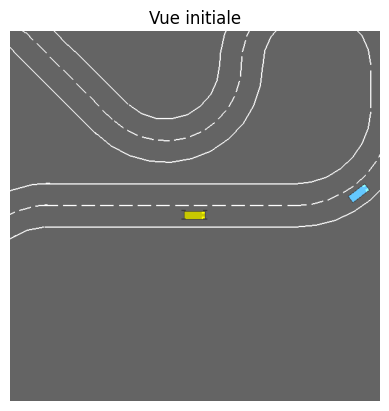

In [3]:
env_vis = gym.make("racetrack-v0", render_mode="rgb_array")
env_vis.unwrapped.configure(cfg)
obs, _ = env_vis.reset()
frame = env_vis.render()


plt.imshow(frame)
plt.axis("off")
plt.title("Vue initiale")
plt.show()

env_vis.close()


In [ ]:
import gymnasium as gym
import highway_env      
from stable_baselines3.common.vec_env import SubprocVecEnv

def make_racetrack_env(config):
    """Retourne une fonction sans argument qui crée l'env (compatible SubprocVecEnv)."""
    def _init():
        import highway_env        # re-import garanti dans chaque subprocess
        env = gym.make("racetrack-v0", render_mode=None)  # pas d'image en training
        env.unwrapped.configure(config)
        return env
    return _init
N_ENVS = 22
N_STEPS = 512  

vec_env = make_vec_env("racetrack-v0",
                       n_envs=N_ENVS,
                       vec_env_cls=SubprocVecEnv,
                       env_kwargs={"config": cfg})


2025-04-24 16:13:24.276055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 16:13:24.276502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 16:13:24.277365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025

ConnectionResetError: [Errno 104] Connection reset by peer

[arg-type]
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/gymnasium/envs/registration.py", line 689, in make
    env_spec = _find_spec(id)
               ^^^^^^^^^^^^^^
  File "/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/gymnasium/envs/registration.py", line 533, in _find_spec
    _check_version_exists(ns, name, version)
  File "/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/gymnasium/envs/registration.py", line 399, in _check_version_exists
    _check_name_exists(ns, name)
  File "/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/gymnasium/envs/registration.py", line 376, in _check_name_exists
    raise error.NameNotFound(
gymnasium.error.NameNotFound: Environment `racetrack` doesn't exist.


Process ForkServerProcess-47:
Traceback (most recent call last):
  File "/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/subproc_vec_env.py", line 29, in _worker
    env = _patch_env(env_fn_wrapper.var())
                     ^^^^^^^^^^^^^^^^^^^^
  File "/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/stable_baselines3/common/env_util.py", line 94, in _init
    env = gym.make(env_id, **kwargs)  # type: ignore[arg-type]
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3

In [ ]:

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

n_cpu = 6
batch_size = 64

env = make_vec_env("racetrack-v0", n_envs=n_cpu)

def scheduler(initial_value):
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule function.
    """
    def func(progress_remaining):
        return progress_remaining * initial_value
    return func



model = PPO("MlpPolicy",
    env,
    policy_kwargs=dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
    n_steps=128, #batch_size * 12 // n_cpu,
    batch_size=batch_size,
    n_epochs=10,
    learning_rate=5e-4,
    gamma=0.9,
    verbose=2,
    tensorboard_log="racetrack_ppo_task_3/") 


model.learn(total_timesteps=int(5e5))


model.save("racetrack_ppo_task_3/model_final_3h")


# Run the algorithm
model = PPO.load("racetrack_ppo_task_3/model_final_3h", env=env)



In [11]:
TOTAL_TS   = 200_000          # par *environnement*
BATCH_SIZE = 1024               # doit diviser BUFFER_SIZE (11264/1024 = 11)
LR         = 2.5e-4
GAMMA      = 0.99
ENT_COEF   = 0.01               # un poil d’entropie pour explorer

model = PPO(
    "MlpPolicy",
    vec_env,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    learning_rate=LR,
    gamma=GAMMA,
    ent_coef=ENT_COEF,
    tensorboard_log=LOG_DIR,
    verbose=1,
)


Using cpu device


In [12]:
start = time.time()
model.learn(total_timesteps=TOTAL_TS,
            tb_log_name="run_fast",
            progress_bar=True)
print(f"Training done in {(time.time()-start)/60:.1f} min")


Logging to ../logs/racetrack_ppo_fast/run_fast_5


Output()

------------------------------
| time/              |       |
|    fps             | 401   |
|    iterations      | 1     |
|    time_elapsed    | 28    |
|    total_timesteps | 11264 |
------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 397          |
|    iterations           | 2            |
|    time_elapsed         | 56           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0005027072 |
|    clip_fraction        | 0.00195      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.171       |
|    learning_rate        | 0.00025      |
|    loss                 | 0.119        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00232     |
|    std                  | 1            |
|    value_loss           | 0.488        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 395          |
|    iterations           | 3            |
|    time_elapsed         | 85           |
|    total_timesteps      | 33792        |
| train/                  |              |
|    approx_kl            | 0.0002529443 |
|    clip_fraction        | 0.000897     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.468        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.00676      |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00308     |
|    std                  | 1            |
|    value_loss           | 0.151        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 393          |
|    iterations           | 4            |
|    time_elapsed         | 114          |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0017772048 |
|    clip_fraction        | 0.00846      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.71         |
|    learning_rate        | 0.00025      |
|    loss                 | 0.26         |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00648     |
|    std                  | 0.989        |
|    value_loss           | 0.774        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 392          |
|    iterations           | 5            |
|    time_elapsed         | 143          |
|    total_timesteps      | 56320        |
| train/                  |              |
|    approx_kl            | 0.0042400495 |
|    clip_fraction        | 0.0161       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.704        |
|    learning_rate        | 0.00025      |
|    loss                 | 2.2          |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00645     |
|    std                  | 0.976        |
|    value_loss           | 4.73         |
------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 390           |
|    iterations           | 6             |
|    time_elapsed         | 172           |
|    total_timesteps      | 67584         |
| train/                  |               |
|    approx_kl            | 0.00079664675 |
|    clip_fraction        | 0.00396       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.39         |
|    explained_variance   | 0.787         |
|    learning_rate        | 0.00025       |
|    loss                 | 1.94          |
|    n_updates            | 50            |
|    policy_gradient_loss | -0.00301      |
|    std                  | 0.972         |
|    value_loss           | 4.62          |
-------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 390          |
|    iterations           | 7            |
|    time_elapsed         | 201          |
|    total_timesteps      | 78848        |
| train/                  |              |
|    approx_kl            | 0.0012834969 |
|    clip_fraction        | 0.0052       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.838        |
|    learning_rate        | 0.00025      |
|    loss                 | 3.87         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00303     |
|    std                  | 0.97         |
|    value_loss           | 9.47         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 389          |
|    iterations           | 8            |
|    time_elapsed         | 231          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0010503519 |
|    clip_fraction        | 0.000311     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.772        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.3         |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00179     |
|    std                  | 0.969        |
|    value_loss           | 37.8         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 386          |
|    iterations           | 9            |
|    time_elapsed         | 262          |
|    total_timesteps      | 101376       |
| train/                  |              |
|    approx_kl            | 0.0016897683 |
|    clip_fraction        | 0.00387      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.792        |
|    learning_rate        | 0.00025      |
|    loss                 | 14           |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00217     |
|    std                  | 0.968        |
|    value_loss           | 34           |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 385          |
|    iterations           | 10           |
|    time_elapsed         | 291          |
|    total_timesteps      | 112640       |
| train/                  |              |
|    approx_kl            | 0.0012349077 |
|    clip_fraction        | 0.00123      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.715        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.3         |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00142     |
|    std                  | 0.968        |
|    value_loss           | 42.6         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 385          |
|    iterations           | 11           |
|    time_elapsed         | 321          |
|    total_timesteps      | 123904       |
| train/                  |              |
|    approx_kl            | 0.0017789435 |
|    clip_fraction        | 0.0012       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.421        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.4         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00124     |
|    std                  | 0.968        |
|    value_loss           | 48.6         |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 385        |
|    iterations           | 12         |
|    time_elapsed         | 350        |
|    total_timesteps      | 135168     |
| train/                  |            |
|    approx_kl            | 0.00232801 |
|    clip_fraction        | 0.00517    |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.39      |
|    explained_variance   | 0.153      |
|    learning_rate        | 0.00025    |
|    loss                 | 19.8       |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.00238   |
|    std                  | 0.967      |
|    value_loss           | 48.2       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 385         |
|    iterations           | 13          |
|    time_elapsed         | 379         |
|    total_timesteps      | 146432      |
| train/                  |             |
|    approx_kl            | 0.002047222 |
|    clip_fraction        | 0.00161     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.47        |
|    learning_rate        | 0.00025     |
|    loss                 | 19.4        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0014     |
|    std                  | 0.966       |
|    value_loss           | 46.7        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 385          |
|    iterations           | 14           |
|    time_elapsed         | 409          |
|    total_timesteps      | 157696       |
| train/                  |              |
|    approx_kl            | 0.0012353808 |
|    clip_fraction        | 0.00119      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.528        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.1         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00177     |
|    std                  | 0.965        |
|    value_loss           | 47.4         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 384          |
|    iterations           | 15           |
|    time_elapsed         | 439          |
|    total_timesteps      | 168960       |
| train/                  |              |
|    approx_kl            | 0.0021487055 |
|    clip_fraction        | 0.00524      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.17         |
|    learning_rate        | 0.00025      |
|    loss                 | 25.1         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00184     |
|    std                  | 0.966        |
|    value_loss           | 57.7         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 384          |
|    iterations           | 16           |
|    time_elapsed         | 469          |
|    total_timesteps      | 180224       |
| train/                  |              |
|    approx_kl            | 0.0023598468 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.0045       |
|    learning_rate        | 0.00025      |
|    loss                 | 23.3         |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00233     |
|    std                  | 0.966        |
|    value_loss           | 51.5         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 383          |
|    iterations           | 17           |
|    time_elapsed         | 499          |
|    total_timesteps      | 191488       |
| train/                  |              |
|    approx_kl            | 0.0028433828 |
|    clip_fraction        | 0.02         |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.00804      |
|    learning_rate        | 0.00025      |
|    loss                 | 27           |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00262     |
|    std                  | 0.965        |
|    value_loss           | 57           |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 382          |
|    iterations           | 18           |
|    time_elapsed         | 529          |
|    total_timesteps      | 202752       |
| train/                  |              |
|    approx_kl            | 0.0023512924 |
|    clip_fraction        | 0.014        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.00302      |
|    learning_rate        | 0.00025      |
|    loss                 | 31.1         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00263     |
|    std                  | 0.966        |
|    value_loss           | 62.3         |
------------------------------------------


Training done in 8.8 min


In [16]:
model_path = os.path.join(MODEL_DIR, f"{MODEL_TAG}.zip")
model.save(model_path)
print("Saved ➜", model_path)

Saved ➜ ../models/ppo_racetrack_fast.zip


In [14]:
# Cellule : test express
test_env = gym.make("racetrack-v0")
test_env.unwrapped.configure(cfg)

obs, _ = test_env.reset()
done = truncated = False
R, L = 0, 0
while not (done or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, r, done, truncated, _ = test_env.step(action)
    R += r; L += 1
print(f"Test rapide ▸ Reward={R:.1f}  |  Length={L}")
test_env.close()


Test rapide ▸ Reward=63.6  |  Length=83


In [15]:
with open("../models/ppo_racetrack_fast_info.txt", "w") as f:
    f.write(f"n_envs      : {N_ENVS}\n")
    f.write(f"n_steps     : {N_STEPS}\n")
    f.write(f"batch_size  : {BATCH_SIZE}\n")
    f.write(f"learning_rate : {LR}\n")
    f.write(f"gamma       : {GAMMA}\n")
    f.write(f"ent_coef    : {ENT_COEF}\n")
    f.write(f"total_ts/env: {TOTAL_TS}\n")
    f.write(f"model_path  : {model_path}\n")
print("✓ Fichier info sauvegardé.")


✓ Fichier info sauvegardé.


usage: ipykernel_launcher.py [-h] [--model MODEL] [--episodes EPISODES]
ipykernel_launcher.py: error: unrecognized arguments: --f=/run/user/36658/jupyter/runtime/kernel-v3cfc495fde1f7af8d35d1aad27924b91dad64b9ba.json


SystemExit: 2

/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
